# Variational autoencoders
Some useful links.

Good theoretical introduction:
https://arxiv.org/pdf/1606.05908.pdf

High-level description:
http://kvfrans.com/variational-autoencoders-explained/

Tensorflow example:
https://jmetzen.github.io/2015-11-27/vae.html

Keras example:

https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py

This notebook is heavily influenced by the keras example.

In [131]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import keras
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K
from keras.layers import Dense, Dropout, Input, Lambda, Layer
from keras.metrics import binary_crossentropy
from keras.models import Model
from scipy.stats import norm

In [132]:
class VariationalLayer(Layer):
    # TODO docstring
    
    def __init__(self, **kwargs):
        # TODO What does this setting do? Can we just set it as a class attribute?
        self.is_placeholder = True
        super().__init__(**kwargs)
    
    def _vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        ''' Compute the variational loss '''
        # x_decoded_mean is a tensor - obtain the appropriate component, and then convert to an integer.
        dim_original = int(x_decoded_mean.shape[1])
        xent_loss = dim_original * binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        loss = self._vae_loss(x, x_decoded_mean, z_mean, z_log_var)
        self.add_loss(loss, inputs=inputs)
        # TODO this isn't used - to what extent does it matter what we return?
        return loss
    

def make_vae(dim_original, n_layers=1, dim_latent=2, dim_intermediate=256):
    ''' Construct a Variational Autoencoder.
    
        Returns (untrained) models for vae, encoder, and decoder.
    '''
    # TODO docstring
    x = Input(shape=(dim_original,))
    
    h = x
    for _ in range(n_layers):
        h = Dense(dim_intermediate, activation='relu')(h)
        h = Dropout(0.2)(h)
        
    # Means and log of the variance for each of the latent variables
    z_mean = Dense(dim_latent)(h)
    z_log_var = Dense(dim_latent)(h)
    
    def sample(args):
        ''' Given (mean, log_var), return samples from N(mean, std) '''
        z_mean, z_log_var = args
        # Construct appropriate number of samples from N(0, 1), depending on the runtime shape of z_mean
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim_latent), mean=0, stddev=1)
        # Rescale by mean & variance
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    # This is a layer which generates samples from z, given appropriate parameter tensors
    z = Lambda(sample, output_shape=(dim_latent,))([z_mean, z_log_var])
    
    # We use these layers in the forward-propagating sense layer. Save them to allow weight re-use.
    decoder_hs = []
    for _ in range(n_layers):
        decoder_hs.append(Dense(dim_intermediate, activation='relu'))
        decoder_hs.append(Dropout(0.2))
    decoder_mean = Dense(dim_original, activation='sigmoid')
    
    def decoder_h(z):
        ''' Apply all elements in decoder_hs '''
        for decoder_layer in decoder_hs:
            z = decoder_layer(z)
        return z
    
    # Instantiate the layers for the vae model - decode the latent variable we've generated into the target space.
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)
    
    y = VariationalLayer()([x, x_decoded_mean, z_mean, z_log_var])
    
    vae = Model(x, y)
    # TODO Presumably we set loss as 'None' here because we called 'add_loss' in VariationalLayer?
    vae.compile(optimizer='adam', loss=None)
    
    # Model which will give the mean of the latent parameter that we are using from points in the input space.
    encoder = Model(x, z_mean)
    
    decoder_input = Input(shape=(dim_latent,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    decoder = Model(decoder_input, _x_decoded_mean)
    
    return vae, encoder, decoder

Load the mnist dataset

In [42]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


Train the VAE on mnist...

In [141]:
vae, encoder, decoder = make_vae(x_train.shape[1])

batch_size = 100

history = vae.fit(
    x_train,
    shuffle=True,
    epochs=50,
    batch_size=batch_size,
    validation_data=(x_test, None))

/home/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: Output "variational_layer_36" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "variational_layer_36" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s - loss: 201.2079 - val_loss: 173.1654
Epoch 2/50
60000/60000 [==============================] - 6s - loss: 172.0732 - val_loss: 167.9480
Epoch 3/50
60000/60000 [==============================] - 7s - loss: 169.3264 - val_loss: 166.1021
Epoch 4/50
60000/60000 [==============================] - 6s - loss: 167.8903 - val_loss: 164.7928
Epoch 5/50
60000/60000 [==============================] - 6s - loss: 166.7598 - val_loss: 163.8539
Epoch 6/50
60000/60000 [==============================] - 7s - loss: 165.7822 - val_loss: 163.0662
Epoch 7/50
60000/60000 [==============================] - 6s - loss: 165.1037 - val_loss: 162.3498
Epoch 8/50
60000/60000 [==============================] - 6s - loss: 164.5121 - val_loss: 161.7943
Epoch 9/50
60000/60000 [==============================] - 6s - loss: 164.0003 - val_loss: 161.2515
Epoch 10/50
60000/60000 [==============================] - 

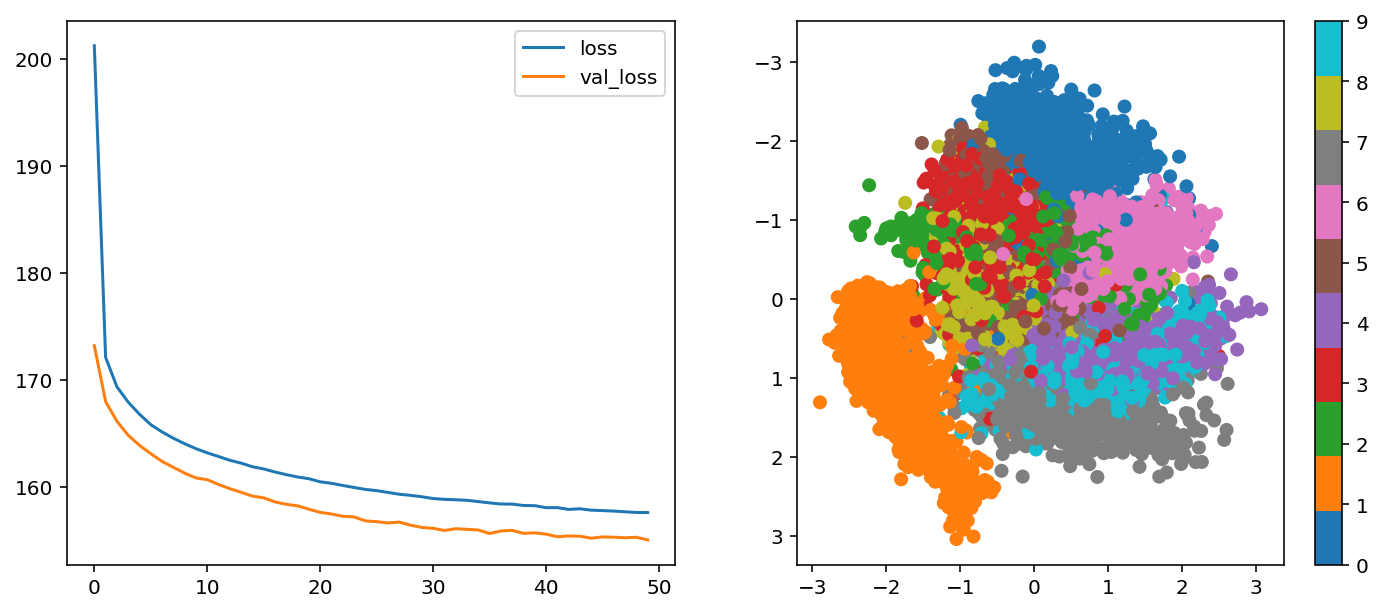

In [142]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend()

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.subplot(1, 2, 2)
# 'tab10' colour map has 10 discrete elements, which is useful for this case.
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')

# Reverse the y-axis, so there is better correspondence with the image below
plt.ylim(plt.ylim()[::-1])
plt.colorbar();

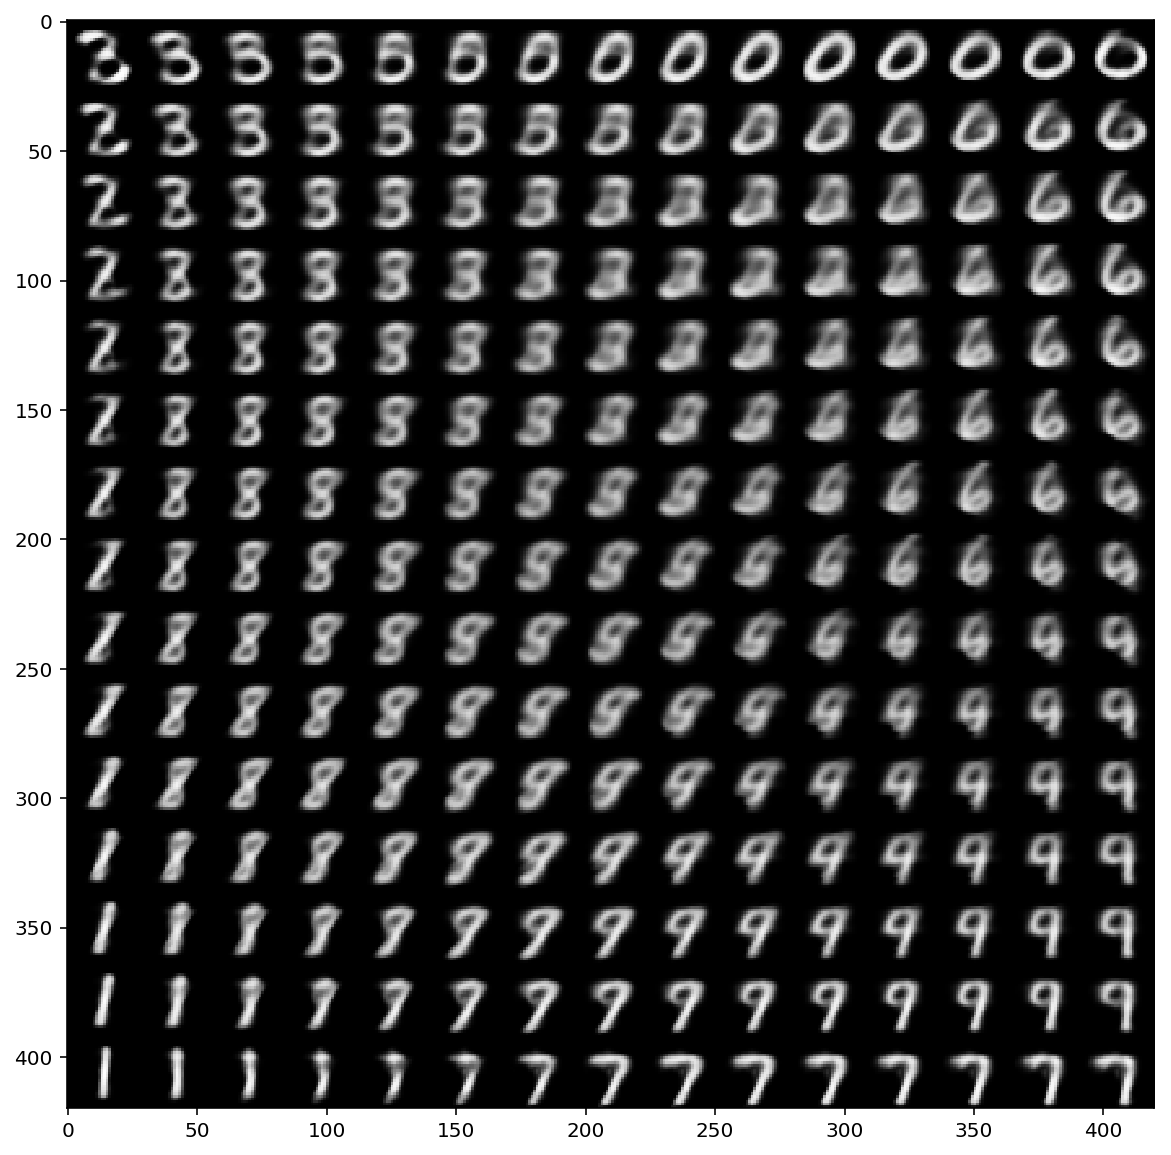

In [143]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r');

# Application to manifold example

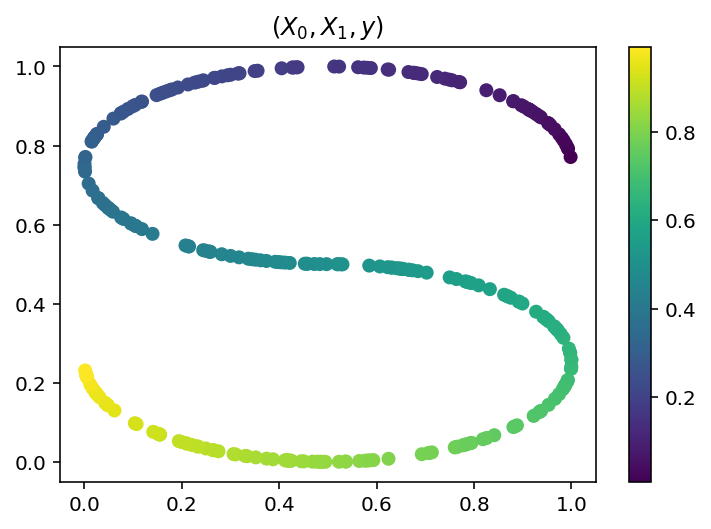

In [147]:
def embed_features(x):
    ''' Given an input vector, apply a transformation to embed it in a higher dimensional space. '''
    assert len(x.shape) == 1, 'Unsupported shape {}'.format(x.shape)

    # TODO add noise, optionally?
    new_X = np.zeros((x.shape[0], 2))

    # This is the true embedding transformation - it creates an S shape in (0, 1) box
    t = 3 * np.pi * (x - 0.5)
    new_X[:, 0] = (1 + np.sin(t)) / 2
    new_X[:, 1] = (np.sign(t) * (np.cos(t) - 1) + 2) / 4

    return new_X

num_samples = 300
x = np.random.random(num_samples)

X = embed_features(x)

plt.title('$(X_0, X_1, y)$')
plt.scatter(X[:, 0], X[:, 1], c=x);
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.colorbar();

In [170]:
vae, encoder, decoder = make_vae(X.shape[1], dim_latent=1, n_layers=1, dim_intermediate=100)

def _fit_model(vae, verbose=0, epochs=500):
     return vae.fit(X, shuffle=True, epochs=epochs, verbose=verbose, validation_data=(X, None))

history = _fit_model(vae)

/home/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: UserWarning: Output "variational_layer_39" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "variational_layer_39" during training.


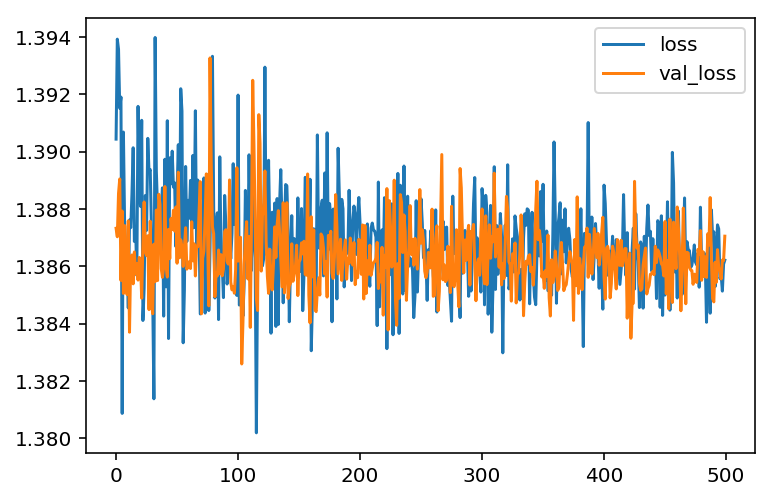

In [171]:
plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.legend();

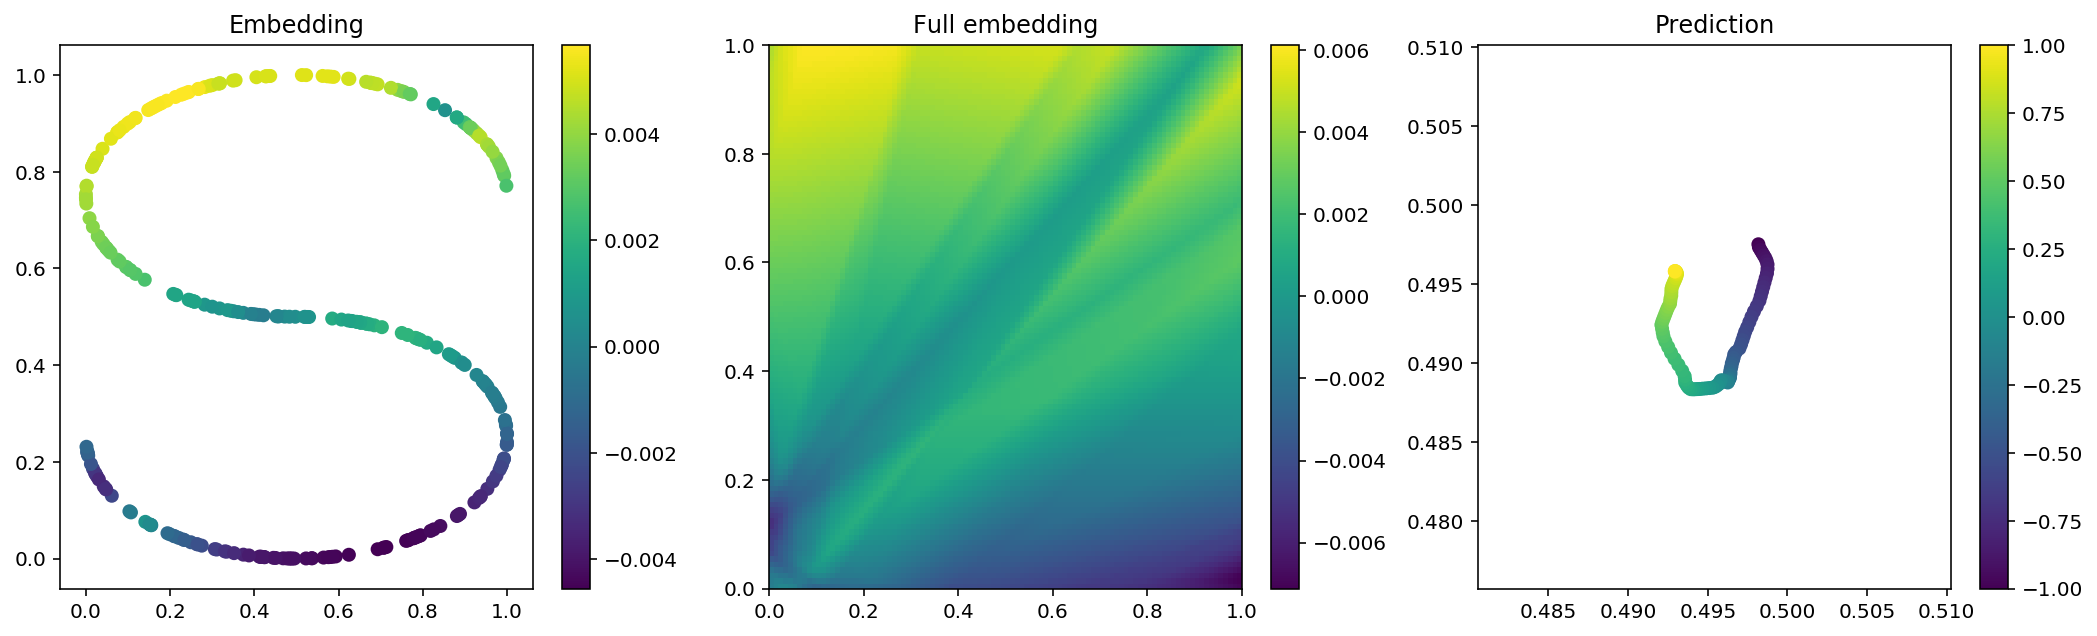

In [174]:
def _plot_decoded_points(decoder_predict, num_grid_points=100):
    ''' Creating a 1D mesh of points in the encoded variable space, see how it maps back into real space '''
    t = np.linspace(-1, 1, num_grid_points)
    X = decoder_predict(t)
    plt.scatter(X[:, 0], X[:, 1], c=t)
    plt.colorbar()
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-0.05, 1.05)

def _make_grid(num_grid_points):
    ''' Make a 2D grid with the given number of points in each dimension '''
    x = np.linspace(0, 1, num_grid_points)
    X0, X1 = np.meshgrid(x, x)
    return np.stack((X0.flatten(), X1.flatten()), axis=1)


def _plot_full_embedding(predictor, num_grid_points=100):
    ''' Given a mapping from X -> t, plot the full embedding '''
    X_full = _make_grid(num_grid_points)
    t_full = predictor(X_full)
    # The imshow command is roughly equivalent to the commented-out scatter call, however should look
    # better, and be much faster.
    # plt.scatter(X_full[:, 0], X_full[:, 1], c=t_full)
    plt.imshow(t_full.reshape((num_grid_points, num_grid_points)), 
               origin='lower', 
               extent=[0, 1, 0, 1], 
               aspect='auto')
    plt.colorbar();
    
def plot_encoder_decoder(encoder, decoder):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title('Embedding')
    plt.scatter(X[:, 0], X[:, 1], c=encoder.predict(X))
    plt.colorbar();

    plt.subplot(1, 3, 2)
    plt.title('Full embedding')
    _plot_full_embedding(encoder.predict)
    
    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    _plot_decoded_points(decoder.predict)

# The encoder is mapping from the input space to the *mean* of the latent variable distribution, E_z[Q(z|x)]
plot_encoder_decoder(encoder, decoder)

What on earth is going on? Broadly speaking, performance is terrible. What we know:

* The range of z_mean is only in roughly [-0.005, 0.005].
* When applying the decoder to z in that range, or even [-1, 1], the space in x obtained is very small.
* Predictive distribution P(x|z) seems tightly centred on (0.5, 0.5)

Hypothesis -- gradient descent is failing to discover the true distribution. In some sense it's trying to approximate the "average" case(?